
## Mount Google Drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Install

### 형태소 분석기 설치


In [2]:
#!java -version
#%pip install PyKomoran
#%pip install konlpy

## Import Library

In [3]:
import os
import pickle

import pandas as pd
import re

from konlpy.tag import Komoran, Okt, Kkma

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
from tqdm import tqdm

## GPU Setting

In [4]:
# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#     raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))


## Hyper_parameters

In [5]:
# Colab
# DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/miso'

# Local
DATA_DIR = '/Users/inseoklee/Desktop/miso/data'
SAVE_DIR = '/Users/inseoklee/Desktop/miso/model/TEST_komoran'
LOAD_DIR = '/Users/inseoklee/Desktop/miso/model/TEST_komoran'

# MAX_LEN -> 패딩 단계에서 설정
EMBEDDING_DIM = 300
NUM_FILTERS = 256
KERNEL_SIZE = 3
HIDDEN_UNITS = 256
DROP_OUT = 0.5

EPOCHS = 20
VERBOSE = 1
BATCH_SIZE = 512
PATIENCE = 5
VALIDATION_SPLIT=0.2

OUTPUT = 7

## Data Load

In [6]:
df = pd.read_csv(DATA_DIR+'/end_sentiment.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123773 entries, 0 to 123772
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    123773 non-null  object
 1   label   123773 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


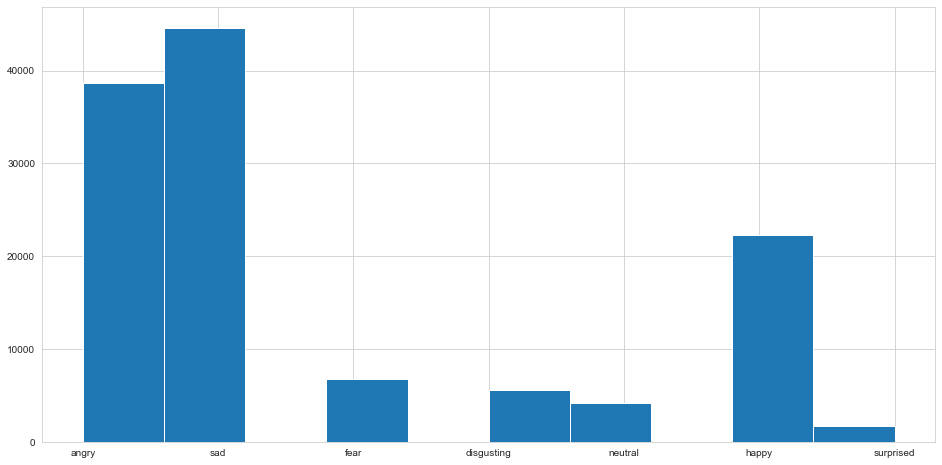

In [8]:
label = df['label']

plt.figure(figsize=(16, 8))
plt.hist(label)
plt.show()

### Train, Test split

In [9]:
X = df.text
y = df.label

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=34, stratify=y
)

In [10]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('\nX_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (99018,)
y_train shape:  (99018,)

X_test shape:  (24755,)
y_test shape:  (24755,)


## Train Data PreProcessing

### Komoran을 이용한 품사(불용어) 제거 및 토큰화

In [13]:
def preprocessing(text, komoran, remove_stopwords=False, stop_words=[]):
    # 함수의 인자는 다음과 같다.
    # text: 전처리할 텍스트
    # okt: okt객체를 반복적으로 생성하지 않고 미리 생성한 후 인자로 받는다.
    # remove_stopwords: 불용어를 제거할지 여부 선택. 기본값은 False
    # stop_words: 불용어 사전은 사용자가 직접 입력.

    # 1. 한글 및 공백을 제외한 문자를 모두 제거
    text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", text)

    # 2. okt 객체를 활용하여 형태소 단위로 나눈다
    word_text = komoran.morphs(text)

    if remove_stopwords:
        word_text = [token for token in word_text if not token in stop_words and len(token) > 1]

    return word_text

In [14]:
stop_words = set(['은', '는', '이', '가', '하', '아', '것', '들', '의', '있', '되', '수', '보', '주', '등', '한'])
komoran = Komoran()
clean_train_text = []

for text in tqdm(X_train):
    # 비어있는 데이터에서 멈추지 않도록 문자열인 경우에만 진행
    if type(text) == str:
        clean_train_text.append(preprocessing(text, komoran, remove_stopwords=True, stop_words=stop_words))
    else:
        clean_train_text.append([]) #string이 아니면 비어있는 값 추가

clean_train_text[:5]

100%|██████████| 99018/99018 [00:33<00:00, 2931.32it/s]


[['급여', '차감', '니까', '짜증', '나서', '회사', '에서'],
 ['으면서', '청소', '매일', '혼자', '청소'],
 ['고맙', '이상', '다니', '기쁘'],
 ['그래도', '공지', '도록', '말씀', '드리', 'ㄹ려구'],
 ['이번', '건강', '검진', '이상']]

## Test Data PreProcessing

### Komoran을 이용한 품사(불용어) 제거 및 토큰화

In [15]:
clean_test_text = []

for text in tqdm(X_test):
    # 비어있는 데이터에서 멈추지 않도록 문자열인 경우에만 진행
    if type(text) == str:
        clean_test_text.append(preprocessing(text, komoran, remove_stopwords=True, stop_words=stop_words))
    else:
        clean_test_text.append([]) #string이 아니면 비어있는 값 추가

clean_test_text[:3]

100%|██████████| 24755/24755 [00:07<00:00, 3190.11it/s]


[['텔레비전',
  '리모컨',
  '기능',
  '사람',
  '알리',
  '어도',
  '무슨',
  'ㄴ지',
  '이해',
  '못하',
  '아서',
  '많이',
  '부끄럽'],
 ['고맙', '밖에'],
 ['친구', '이랑', '싸우', '선생님', '따돌림', '당하', '다고', '오해', '자꾸', '상담실', '오래']]

### 토큰 데이터 벡터화(토큰을 숫자로 변환하고 tokenizer를 파일에 저장)

In [16]:
tokenizer_name = 'tokenizer.pickle'
save_path = os.path.join(SAVE_DIR, tokenizer_name)

tokenizer = Tokenizer(oov_token = True)

try:
    tokenizer.fit_on_texts(clean_train_text)
    train_sequences = tokenizer.texts_to_sequences(clean_train_text)
    test_sequences = tokenizer.texts_to_sequences(clean_test_text)
except:
    print('Already tokenized')

with open(save_path, 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

vocab_size = len(tokenizer.word_index)+1 # 단어의 수
vocab_size

train_sequences[:5]

[[1445, 6685, 33, 67, 198, 21, 7],
 [434, 157, 133, 74, 157],
 [108, 188, 62, 117],
 [144, 2985, 439, 215, 178, 3801],
 [42, 39, 294, 188]]

In [17]:
# tokenizer.word_index

### Padding

텍스트의 최대 길이 : 36
텍스트의 평균 길이 : 6.94375770062009


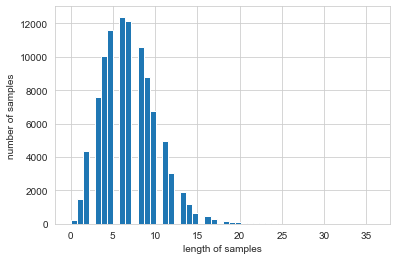

In [19]:
print('텍스트의 최대 길이 :',max(len(text) for text in train_sequences))
print('텍스트의 평균 길이 :',sum(map(len, train_sequences))/len(train_sequences))
plt.hist([len(text) for text in train_sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
trunc_type = 'post'
padding_type = 'post'
MAX_LEN = 10

X_train = pad_sequences(train_sequences, maxlen=MAX_LEN, padding=padding_type, truncating=trunc_type)
X_test= pad_sequences(test_sequences, maxlen=MAX_LEN, padding=padding_type, truncating=trunc_type)

In [21]:
print(X_train[:5])

[[1445 6685   33   67  198   21    7    0    0    0]
 [ 434  157  133   74  157    0    0    0    0    0]
 [ 108  188   62  117    0    0    0    0    0    0]
 [ 144 2985  439  215  178 3801    0    0    0    0]
 [  42   39  294  188    0    0    0    0    0    0]]


### Labeling

In [22]:
y_train.unique()

array(['sad', 'angry', 'happy', 'disgusting', 'neutral', 'fear',
       'surprised'], dtype=object)

In [23]:
emo_dic = {
    'angry': 0, 'sad': 1, 'fear': 2, 'disgusting': 3, 'neutral': 4, 'happy': 5, 'surprised': 6
}

In [24]:
y_train = y_train.replace(emo_dic)
y_test = y_test.replace(emo_dic)
y_train.unique()

array([1, 0, 5, 3, 4, 2, 6])

## Model definition

In [25]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, mask_zero=True, input_length=MAX_LEN))
model.add(Dropout(DROP_OUT))
model.add(Conv1D(NUM_FILTERS, KERNEL_SIZE, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(HIDDEN_UNITS, activation='relu'))
model.add(Dropout(DROP_OUT))
model.add(Dense(OUTPUT, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=VERBOSE, patience=PATIENCE)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=VERBOSE, save_best_only=True)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Metal device set to: Apple M1


2022-07-14 09:52:10.020173: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-14 09:52:10.020384: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Train Model

In [26]:
history = model.fit(
    X_train, y_train, epochs=EPOCHS, callbacks=[es, mc], batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT
)

Epoch 1/20


2022-07-14 09:52:13.050071: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  1/155 [..............................] - ETA: 1:02 - loss: 1.9551 - accuracy: 0.1055

2022-07-14 09:52:13.275748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


155/155 [==============================] - ETA: 0s - loss: 1.2832 - accuracy: 0.4926

2022-07-14 09:52:21.037978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.63724, saving model to best_model.h5
155/155 [==============================] - 9s 54ms/step - loss: 1.2832 - accuracy: 0.4926 - val_loss: 0.9731 - val_accuracy: 0.6372
Epoch 2/20
154/155 [============================>.] - ETA: 0s - loss: 0.8929 - accuracy: 0.6646
Epoch 2: val_accuracy improved from 0.63724 to 0.67244, saving model to best_model.h5
155/155 [==============================] - 8s 50ms/step - loss: 0.8929 - accuracy: 0.6647 - val_loss: 0.8585 - val_accuracy: 0.6724
Epoch 3/20
155/155 [==============================] - ETA: 0s - loss: 0.7793 - accuracy: 0.7061
Epoch 3: val_accuracy improved from 0.67244 to 0.67643, saving model to best_model.h5
155/155 [==============================] - 8s 53ms/step - loss: 0.7793 - accuracy: 0.7061 - val_loss: 0.8379 - val_accuracy: 0.6764
Epoch 4/20
155/155 [==============================] - ETA: 0s - loss: 0.7123 - accuracy: 0.7313
Epoch 4: val_accuracy did not improve from 0.67643
155/155 [

## Test Model

In [27]:
loaded_model = load_model('best_model.h5')
loss, acc = loaded_model.evaluate(X_test, y_test)

print('Test loss:', loss)
print('Test accuracy:', acc)

 14/774 [..............................] - ETA: 6s - loss: 0.9270 - accuracy: 0.6518

2022-07-14 09:53:16.502105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


774/774 [==============================] - 6s 7ms/step - loss: 0.8531 - accuracy: 0.6762
Test loss: 0.8530535101890564
Test accuracy: 0.6761866211891174


### Visualization

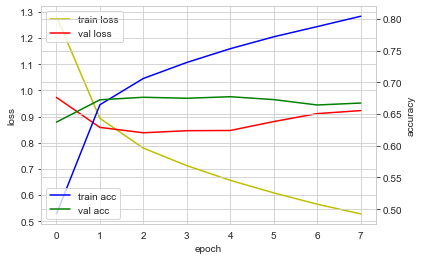

In [28]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## Save Model

In [29]:
model_name = 'trained_model.h5'

# Save model and weights
model_path = os.path.join(SAVE_DIR, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/inseoklee/Desktop/miso/model/TEST_komoran/trained_model.h5 


## Evaluation

### confusion matrix

In [30]:
y_pred = loaded_model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
print(y_pred)

 36/774 [>.............................] - ETA: 3s

2022-07-14 09:53:34.856445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


774/774 [==============================] - 3s 4ms/step
[0 1 0 ... 1 2 0]


[[5070 1746  165  107   78  558   11]
 [1405 6376  211   98   62  760   13]
 [ 149  161  927   14    9   73   23]
 [ 136  138   15  772   15   32    8]
 [ 104  168   25   11  462   60    2]
 [ 566  816   84   27   41 2915    3]
 [  14   34   32   18    8   16  217]]


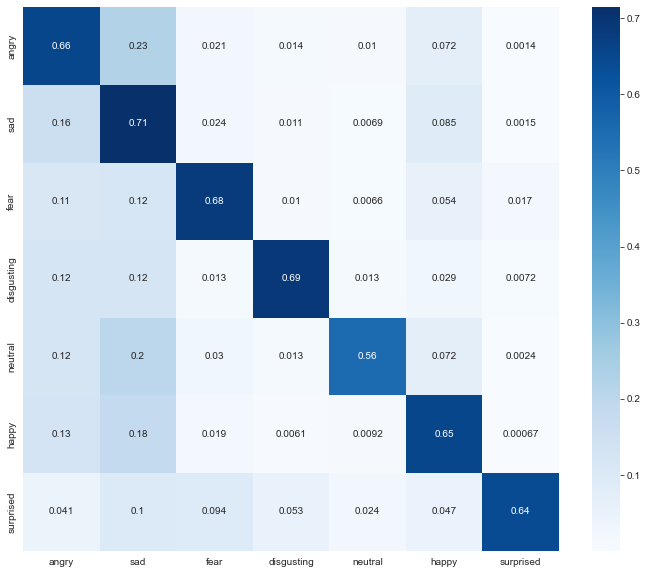

In [31]:
# constant for classes
classes = ('angry', 'sad', 'fear', 'disgusting', 'neutral', 'happy', 'surprised')

# Build confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix/cf_matrix.sum(axis=1).reshape(7, 1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True, cmap='Blues')
plt.savefig(SAVE_DIR + '/output.png')

### precision, recall, f1 score

In [32]:
acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred, average='macro')
re_score = recall_score(y_test, y_pred, average='macro')
f1_score = f1_score(y_test, y_pred, average='macro')
print("accuracy_score: ", acc_score)
print("precision_score: ", prec_score)
print("recall_score: ", re_score)
print("f1_score: ", f1_score)

accuracy_score:  0.6761866289638457
precision_score:  0.6939326978825494
recall_score:  0.6564875564805367
f1_score:  0.6728743750078799


## Load Model

In [33]:
def load_tokenizer(path):
    with open(path, 'rb') as f:
        tokenizer = pickle.load(f)
    return tokenizer

model_name = 'trained_model.h5'
tokenizer_name = 'tokenizer.pickle'
model_path = os.path.join(LOAD_DIR, model_name)
tokenizer_path = os.path.join(LOAD_DIR, tokenizer_name)

model = load_model(model_path)
tokenizer = load_tokenizer(tokenizer_path)


In [35]:
def getResult(predict) :
    highest = 0
    highestIdx = 0
    for x in range (0,len(predict)) :
        if(predict[x] > highest) :
            highestIdx = x
            highest =predict[x]
    return highestIdx

def predict_sentiment(text, model):
    tokens = []
    if type(text) == str:
        tokens.append(preprocessing(text, komoran, remove_stopwords=True, stop_words=stop_words))
    else:
        tokens.append([]) #string이 아니면 비어있는 값 추가
    token_sequences = tokenizer.texts_to_sequences(tokens)
    if(len(token_sequences) == 0) :
        return "너무 짧아"
    padded_sequences = pad_sequences(token_sequences, maxlen=MAX_LEN)
    predict = model.predict(padded_sequences)
    print(predict)
    result = getResult(predict[0])
    if result == 0 :
        return 'angry'
    elif result == 1 :
        return 'sad'
    elif result == 2 :
        return 'fear'
    elif result == 3 :
        return 'disgusting'
    elif result == 4 :
        return 'neutral'
    elif result == 5 :
        return 'happy'
    elif result == 6 :
        return 'surprised'

In [36]:
predict_sentiment("너 엄마가 일찍 들어오라고 했어 안했어.", model)

1/1 [==============================] - 0s 65ms/step
[[0.4532698  0.4076351  0.00908537 0.00958376 0.00310793 0.11629651
  0.00102162]]


2022-07-14 09:54:03.592813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


'angry'

In [37]:
predict_sentiment("친구가 다쳐서 병문안 가야돼.", model)

1/1 [==============================] - 0s 12ms/step
[[0.07833219 0.00915103 0.8872444  0.00342248 0.00673914 0.00474525
  0.01036553]]


'fear'